# Classifying elliptic curves by complex multiplication

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from tqdm.notebook import *
from math import *
from livelossplot import PlotLosses
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from helpers import *

In [158]:
df = pd.read_csv("output/dataset.csv")

In [159]:
df.head()

,A2,A3,A5,A7,A11,A13,A17,A19,A23,A29,...,A9901,A9907,A9923,A9929,A9931,A9941,A9949,A9967,A9973,CM
0,0.000000,0.577350,0.000000,0.000000,0.000000,-0.27735,0.000000,0.917663,1.668115,1.114172,...,0.532643,0.934355,0.331278,-0.541927,1.264370,-1.384089,-0.421075,-1.302150,-1.862516,0.0
1,0.707107,0.000000,0.447214,1.511858,0.000000,-1.10940,1.455214,-0.688247,-0.208514,0.000000,...,1.507481,1.547211,-1.264879,0.311106,1.314543,0.702074,1.584044,0.220364,1.361840,0.0
2,-0.707107,0.000000,-0.447214,0.000000,1.206045,-1.10940,-1.455214,0.458831,0.000000,1.856953,...,-1.286383,-0.874074,0.301162,-1.384925,-0.200694,0.140415,-1.142918,-0.030050,0.961299,0.0
3,0.000000,-1.154701,0.000000,-1.511858,-0.904534,0.55470,0.000000,0.458831,1.251086,-1.671258,...,-0.311546,1.587399,-1.415460,1.384925,-0.762636,-0.300889,1.193046,1.041720,-1.061434,0.0
4,-1.414214,0.000000,0.000000,1.133893,0.000000,-0.55470,0.727607,0.917663,0.000000,-0.928477,...,-0.693441,-0.170796,0.582246,0.511820,0.070243,-0.742193,1.162969,0.130215,1.061434,0.0


In [161]:
SOPHIE_GERMAIN = False
if not SOPHIE_GERMAIN:
    X = np.array(df)
    X = np.delete(X, len(X[0])-1, 1)
    Y = np.array(df["CM"])
    indexes = df.columns.values[:-1]
else:
    indexes=[]
    for x in df.columns.values:
        if x == "CM":
            continue
        if is_sg(int(x[1:])) or is_safe(int(x[1:])):
            indexes.append(x)
    X = np.array(df[indexes])
    Y = np.array(df["CM"])

In [162]:
X.shape

(5000, 1229)

In [163]:
Y.shape

(5000,)

In [164]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, shuffle = True)
assert 0.4 < len(Y_train[Y_train==1])/len(Y_train) < 0.6
assert 0.4 < len(Y_test[Y_test==1])/len(Y_test) < 0.6

In [149]:
def ma_sampling(x: list, win = 28): # For pretty plots
    assert len(x)>win, "Window too large!"
    cur_sum = sum(x[:win])
    cur_pos = win - 1
    sampled = []
    for i in range(len(x)-win):
        sampled.append(cur_sum/win)
        cur_sum -= x[cur_pos-win]
        cur_pos += 1
        cur_sum += x[cur_pos]
    return sampled

In [150]:
def acc(X,Y):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = torch.tensor(X[i], dtype=torch.double).float()
        y = Y[i]
        _y = model(x)
        if _y[0] > _y[1]:
            cls = 0
        else:
            cls = 1
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

## Neural network model

/usr/local/lib/python3.9/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


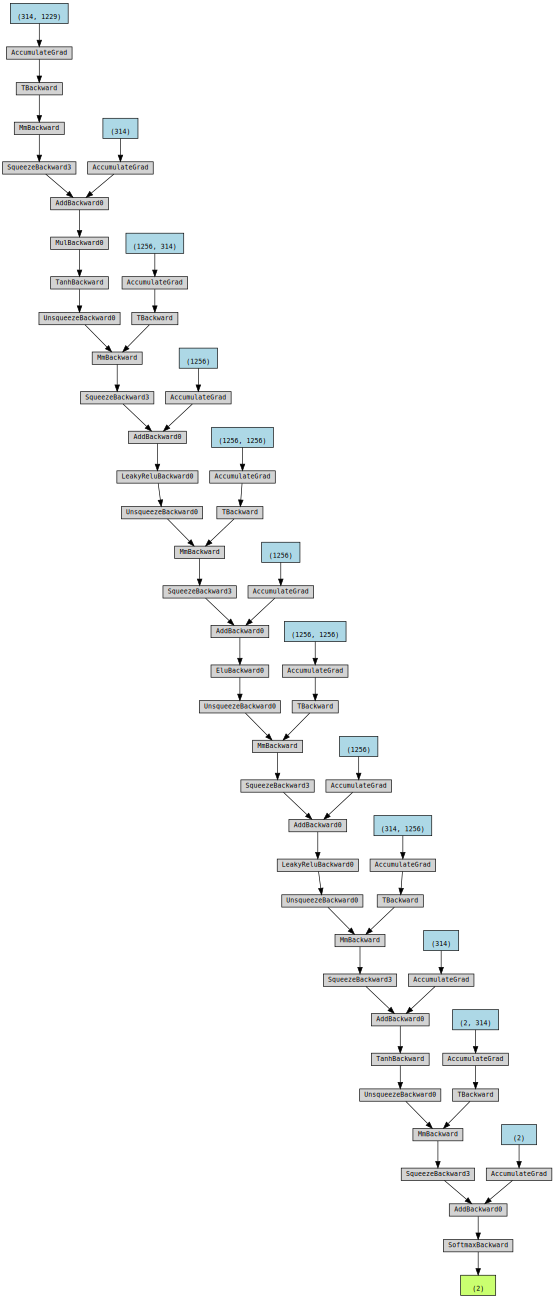

In [95]:
from torchviz import make_dot
DATA_SIZE = len(X[0])
N_EPOCHS = 2000
N_DISPLAY = 20
SAMPLE_SIZE = 100
A=314
k=4
model = nn.Sequential(
        nn.Linear(DATA_SIZE, A),
        nn.Dropout(0.1),
        nn.Tanh(),
        nn.Linear(A, k*A),
        nn.LeakyReLU(),
        nn.Linear(k*A, k*A),
        nn.ELU(),
        nn.Linear(k*A, k*A),
        nn.LeakyReLU(),
        nn.Linear(k*A, A),
        nn.Tanh(),
        nn.Linear(A, 2),
        nn.Softmax()
)
criterion = nn.CrossEntropyLoss() # The MOST inconvinient criterion ever!
optimizer = optim.SGD(model.parameters(), lr=0.01)
#print("Untrained accuracy(test): %.3f"%acc(X_test, Y_test))
#print("Untrained accuracy(train): %.3f"%acc(X_train, Y_train))
x = torch.tensor(X[0], dtype=torch.double).float()
y = model(x)
make_dot(y)

In [96]:
losses = []
plotlosses = PlotLosses()
avg_loss_lr = 0.0
avg_accuracy = 0.0
for i in tnrange(N_EPOCHS):
    indices = np.random.choice(X_train.shape[0], SAMPLE_SIZE, replace=False)
    sample_x = X_train[indices]
    sample_y = Y_train[indices]
    avg_loss = 0.0
    for j in range(SAMPLE_SIZE):
        x = torch.Tensor(sample_x[j])
        target = torch.Tensor([int(sample_y[j])]).type(torch.LongTensor)
        optimizer.zero_grad()   
        output = model(x)
        output = output.reshape((1,2)).float()
        loss = criterion(output, target)
        avg_loss += float(loss)
        loss.backward()
        optimizer.step()
    avg_loss /= SAMPLE_SIZE
    avg_loss_lr += avg_loss
    #avg_accuracy += acc(X_test, Y_test)
    if i % N_DISPLAY == 0 and i > 0:
        avg_loss_lr /= N_DISPLAY
        #avg_accuracy /= N_DISPLAY
        plotlosses.update({"Loss": avg_loss_lr, "Accuracy": acc(X_test, Y_test)})
        plotlosses.send()
        avg_loss_lr = 0.0
        avg_accuracy = 0.0
    losses.append(avg_loss)

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


KeyboardInterrupt: 

In [ ]:
plt.plot(ma_sampling(losses))
plt.show()

In [ ]:
print("Acc(train): %.3f"%acc(X_train, Y_train))
print("Acc(test): %.3f"%acc(X_test, Y_test))

As it can be seen neural networks are absolutely useless for classifying _~~anything~~_ elliptic curves.

## Naive Bayesian classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
naive_bayes = GaussianNB()
naive_bayes.fit(X_train , Y_train)
Y_predicted = naive_bayes.predict(X_test)
print("Acc: %.3f" % metrics.accuracy_score(Y_predicted , Y_test))

## Convolutional neural network

In [ ]:
model = nn.Sequential(
        nn.Conv1d(1, 1, 64),
        nn.MaxPool1d(8),
        nn.LeakyReLU(),
        nn.Linear(145,290),
        nn.Tanh(),
        nn.Linear(290,145),
        nn.LeakyReLU(),
        nn.Linear(145,2)
)
x = torch.tensor(X_train[0], dtype=torch.double).float().reshape((1,1,1229))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
def acc(X,Y):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = torch.tensor(X[i], dtype=torch.double).float().reshape((1,1,1229))
        y = Y[i]
        _y = model(x)
        if _y[0][0][0] > _y[0][0][1]:
            cls = 0
        else:
            cls = 1
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

In [ ]:
DATA_SIZE = len(X[0])
N_EPOCHS = 800
N_DISPLAY = 20
SAMPLE_SIZE = 100
losses = []
plotlosses = PlotLosses()
avg_loss_lr = 0.0
avg_accuracy = 0.0
for i in tnrange(N_EPOCHS):
    indices = np.random.choice(X_train.shape[0], SAMPLE_SIZE, replace=False)
    sample_x = X_train[indices]
    sample_y = Y_train[indices]
    avg_loss = 0.0
    for j in range(SAMPLE_SIZE):
        x = torch.Tensor(sample_x[j]).reshape((1,1,1229))
        target = torch.Tensor([int(sample_y[j])]).type(torch.LongTensor)
        optimizer.zero_grad()   
        output = model(x)
        output = output[0]
        loss = criterion(output, target)
        avg_loss += float(loss)
        loss.backward()
        optimizer.step()
    avg_loss /= SAMPLE_SIZE
    avg_loss_lr += avg_loss
    #avg_accuracy += acc(X_test, Y_test)
    if i % N_DISPLAY == 0 and i > 0:
        avg_loss_lr /= N_DISPLAY
        #avg_accuracy /= N_DISPLAY
        plotlosses.update({"Loss": avg_loss_lr, "Accuracy": acc(X_test, Y_test)})
        plotlosses.send()
        avg_loss_lr = 0.0
        avg_accuracy = 0.0
    losses.append(avg_loss)

In [ ]:
print("Acc(train): %.3f"%acc(X_train, Y_train))
print("Acc(test): %.3f"%acc(X_test, Y_test))

Is this magic of random intialization?...or convolutional networks really suitable for working with big vectors? Anyway, lets save this network:

In [ ]:
torch.save(model, "output/magic.th")

## Decision tree classifier


In [165]:
from sklearn import tree
import matplotlib

matplotlib.rc('figure', figsize=(20, 20))

In [166]:
model = tree.DecisionTreeClassifier()
model = model.fit(X_train, Y_train)

In [167]:
def acc(X,Y,fn):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = X[i]
        y = Y[i]
        _y = fn([x])
        cls = _y[0]
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

In [168]:
acc(X_test, Y_test, model.predict)

0.9948

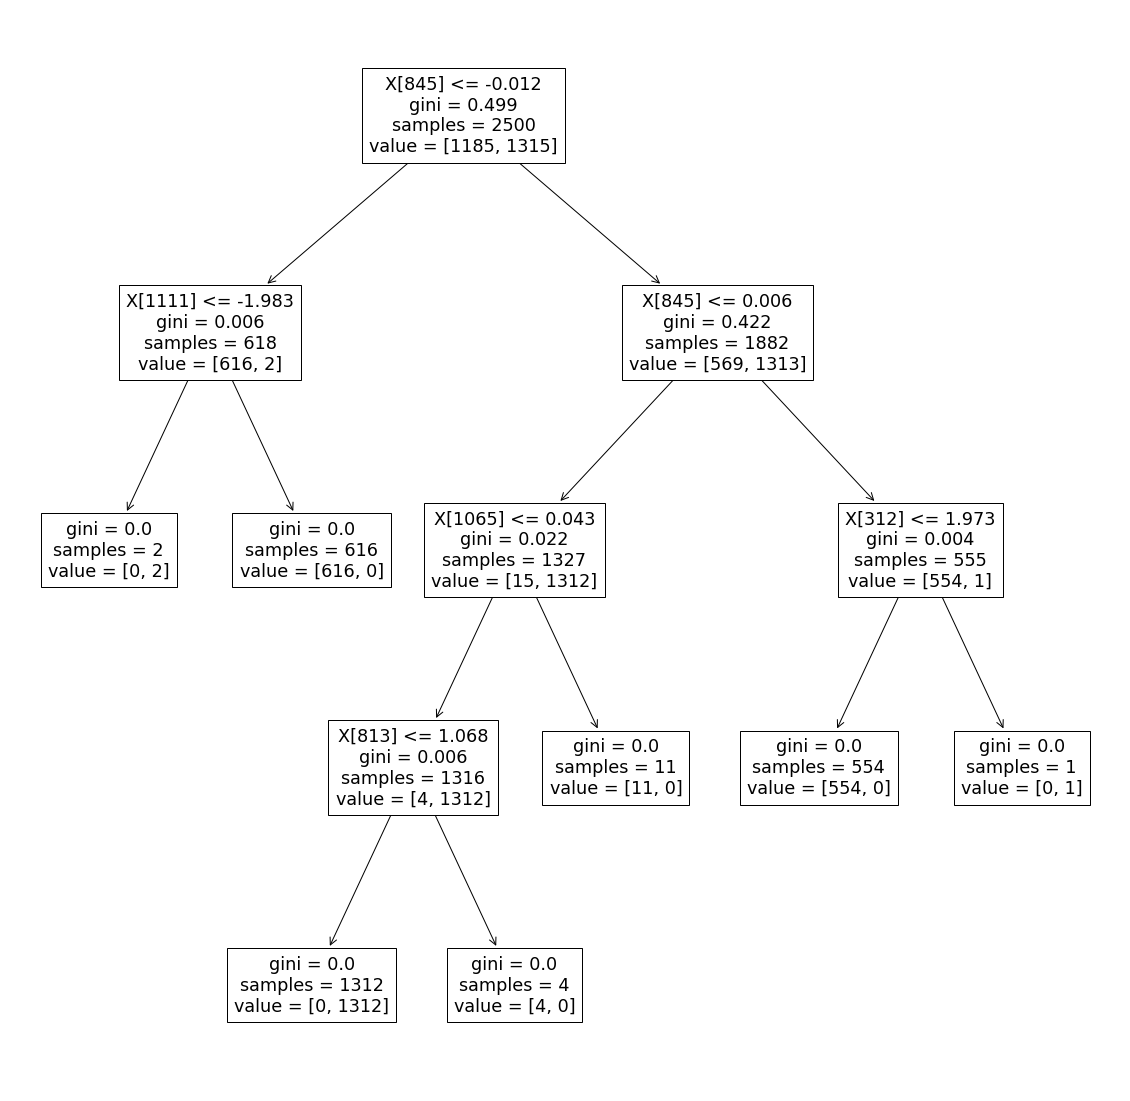

In [169]:
tree.plot_tree(model)
plt.plot(figsize=(10,10))
plt.show()

In [170]:
r = tree.export_text(model)

In [171]:
importances = list(model.feature_importances_)
for i in range(len(importances)):
    if importances[i] > 0.0:
        print(f"{indexes[i]} has importance {importances[i]}")

A2081 has importance 0.0016014474309704837
A6263 has importance 0.006397846890453787
A6551 has importance 0.9714072125937407
A8543 has importance 0.017395200889794533
A8941 has importance 0.0031982921950403677


## Bootstrap
Lets build tree many(e.g. 20) times and see which features would be most important and whether corresponiding index is Sophie-Germain prime or safe prime.

In [172]:
def bootstrap_best_feature():
    model = tree.DecisionTreeClassifier()
    model = model.fit(X_train, Y_train)
    importances = list(model.feature_importances_)
    best_feature_n = None
    best_score = 0.0
    for feature_n in range(len(importances)):
        if importances[feature_n] > best_score:
            best_score = importances[feature_n]
            best_feature_n = feature_n
    return best_feature_n, best_score

In [193]:
best_coefs = []
n = 100
n_sg = 0
n_safe = 0
total_score = 0.0
for i in tnrange(n):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, shuffle = True)
    n_feature, score = bootstrap_best_feature()
    total_score += score
    prime = int(indexes[n_feature][1:])
    if is_sg(prime):
        n_sg += 1
    if is_safe(prime):
        n_safe += 1
    best_coefs.append(prime)
    print(prime, "score=", acc(X_test, Y_test, model.predict))
print(f"n_sg={n_sg}")
print(f"n_safe={n_safe}")
print(f"avg_score={total_score/n}")

  0%|          | 0/100 [00:00<?, ?it/s]

6047 score= 0.9976
7727 score= 0.9972
4703 score= 0.9968
8543 score= 0.9976
8951 score= 0.9972
3527 score= 0.9976
8543 score= 0.9976
8543 score= 0.9976
8543 score= 0.998
7727 score= 0.9964
7727 score= 0.9976
5903 score= 0.9972
7727 score= 0.9984
8543 score= 0.9968
7727 score= 0.9968
1847 score= 0.9964
8543 score= 0.9976
8543 score= 0.9964
8543 score= 0.9976
8543 score= 0.9984
3527 score= 0.998
6551 score= 0.9968
6599 score= 0.9972
8543 score= 0.9968
7727 score= 0.9976
8543 score= 0.9972
8543 score= 0.998
3527 score= 0.998
6047 score= 0.9972
9743 score= 0.9976
8543 score= 0.9976
8951 score= 0.998
6551 score= 0.998
6551 score= 0.996
9323 score= 0.9968
7727 score= 0.9976
3167 score= 0.9984
8951 score= 0.9988
8543 score= 0.9976
8543 score= 0.9968
8543 score= 0.9976
8543 score= 0.9968
6551 score= 0.9972
7727 score= 0.9956
8543 score= 0.9992
7727 score= 0.9968
8543 score= 0.9984
8543 score= 0.998
8543 score= 0.9964
7727 score= 0.9976
6299 score= 0.9968
8543 score= 0.998
8447 score= 0.998
760

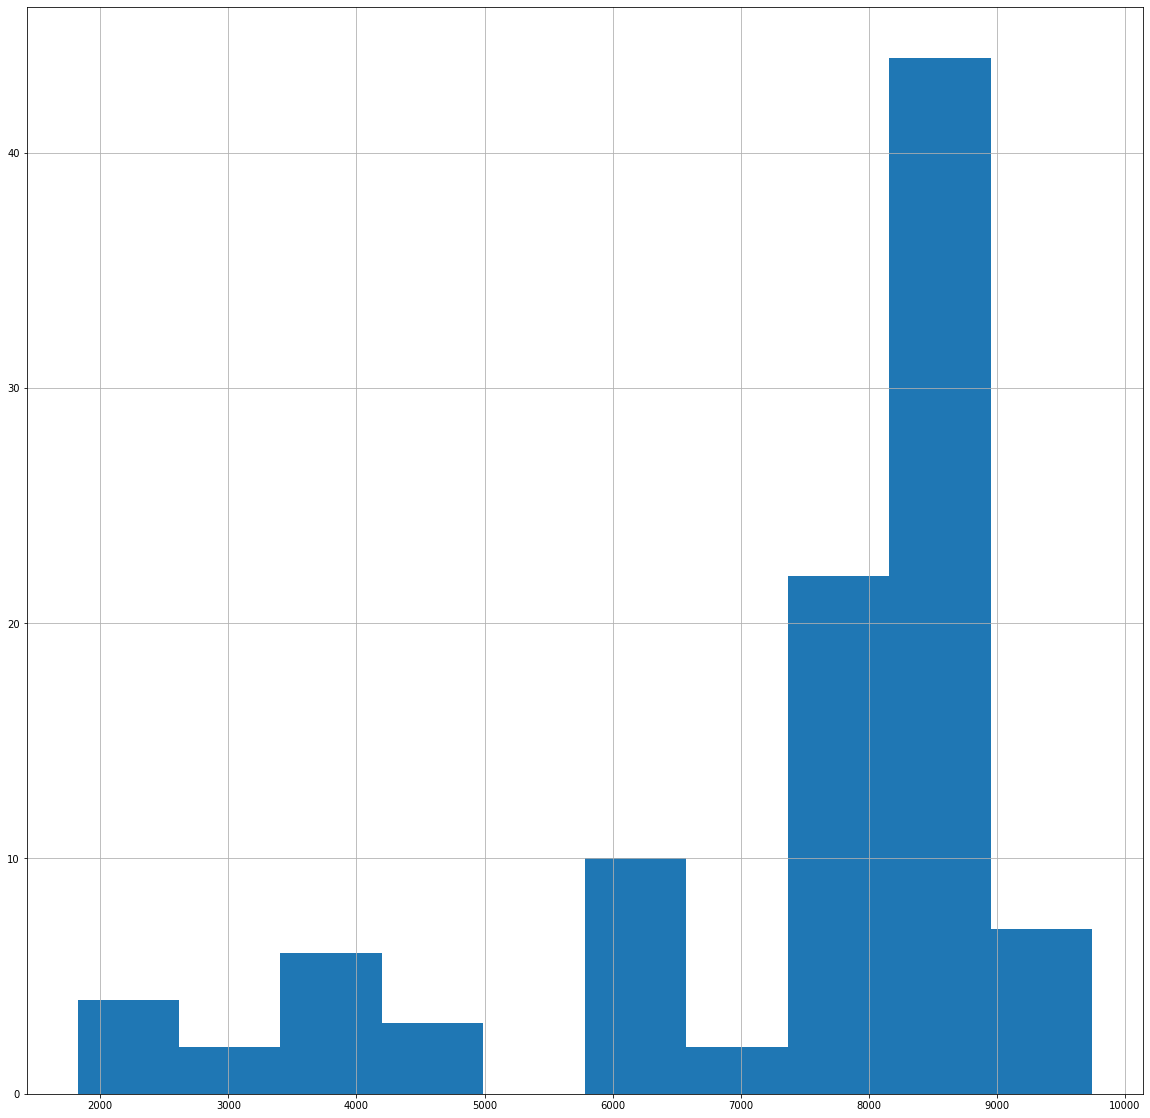

In [194]:
plt.hist(best_coefs)
plt.grid()
plt.show()

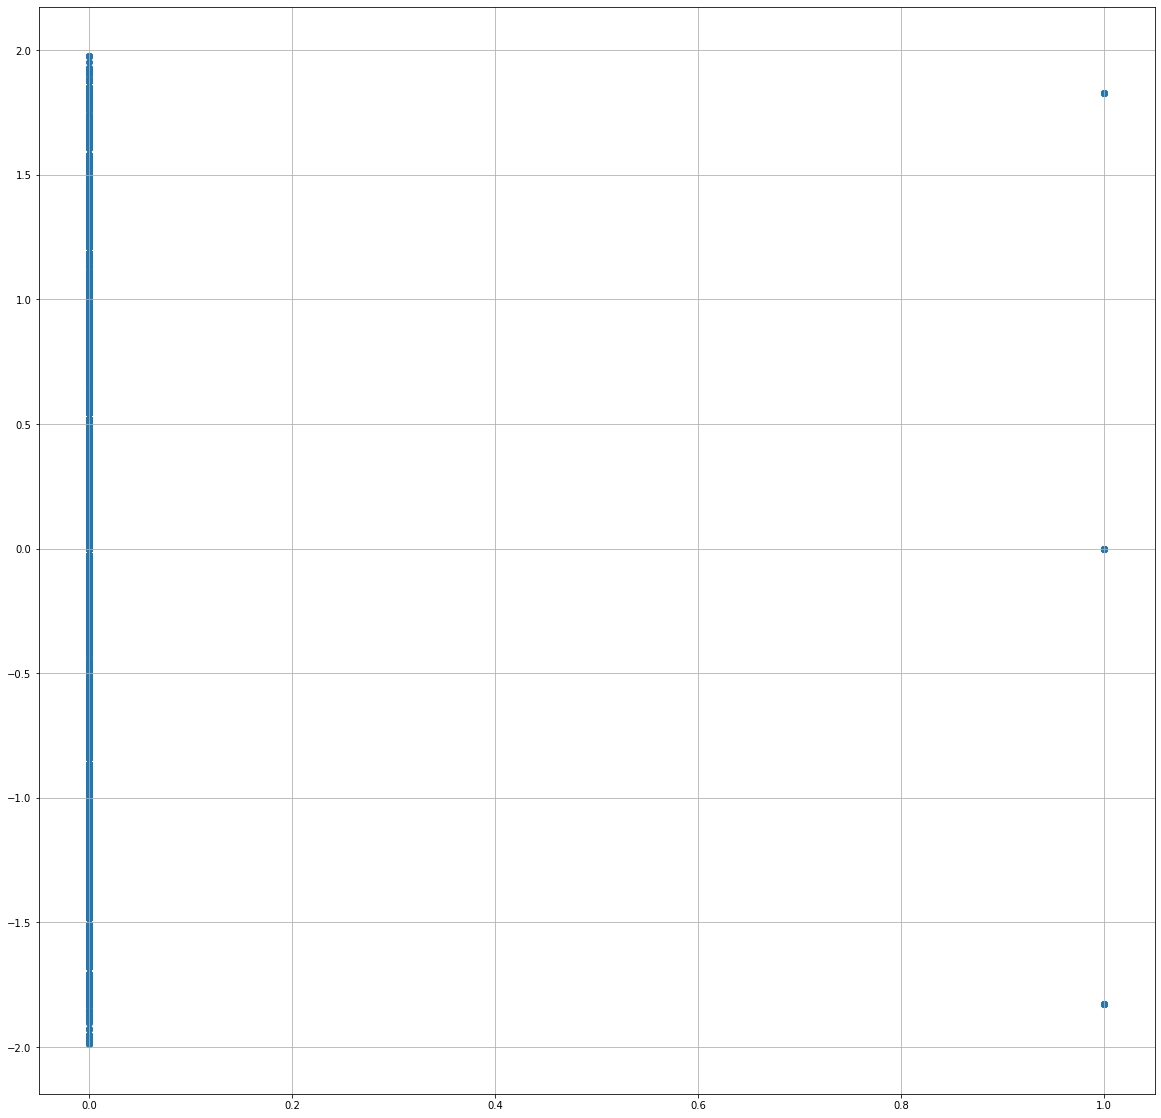

In [195]:
plt.grid()
plt.scatter(df["CM"],df["A6551"])
plt.show()

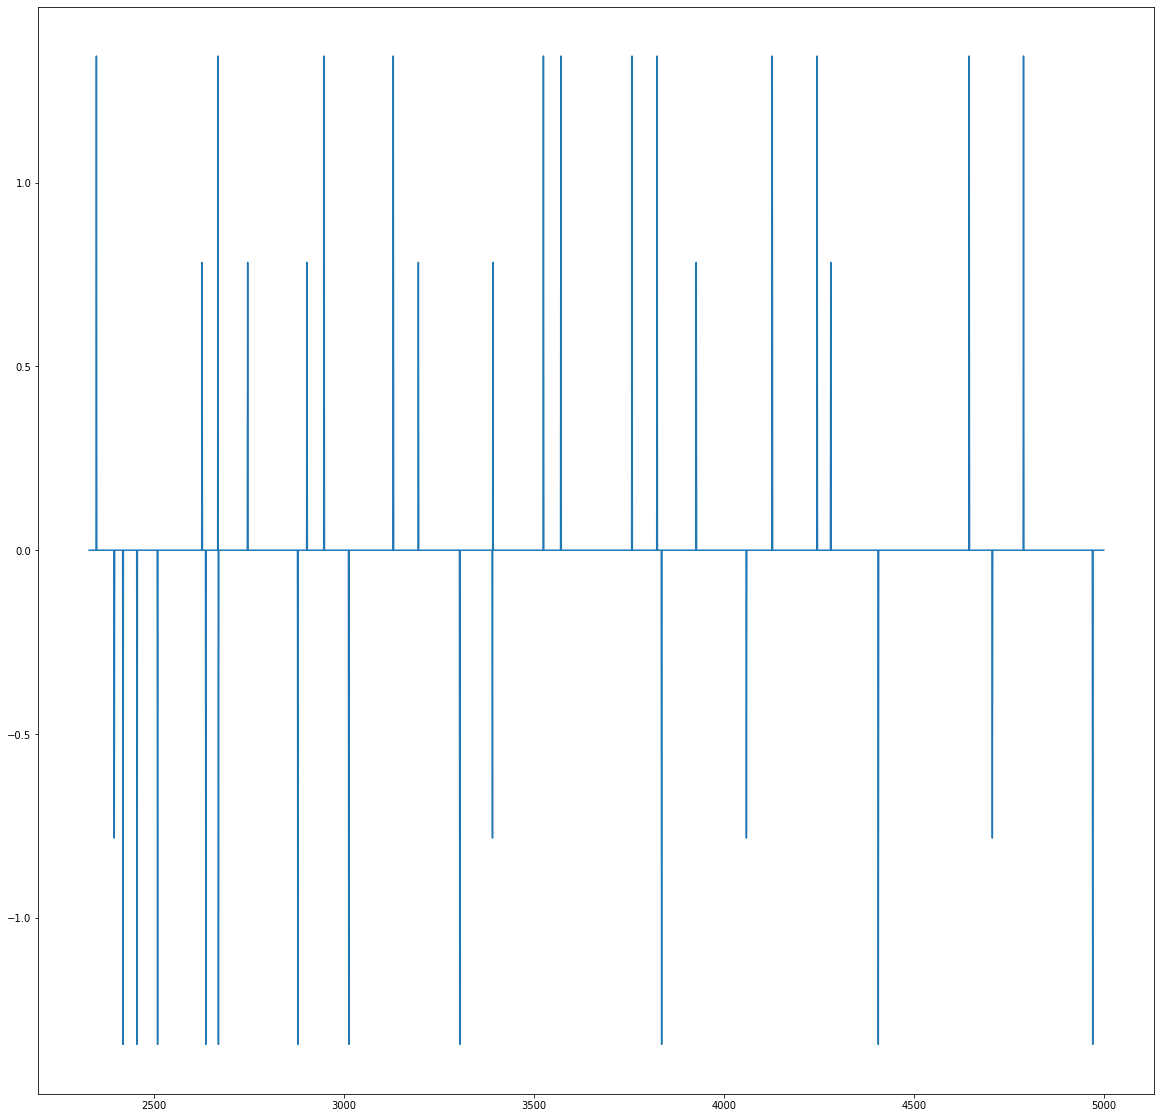

In [196]:
plt.plot(df[df["CM"]==1]["A4583"])

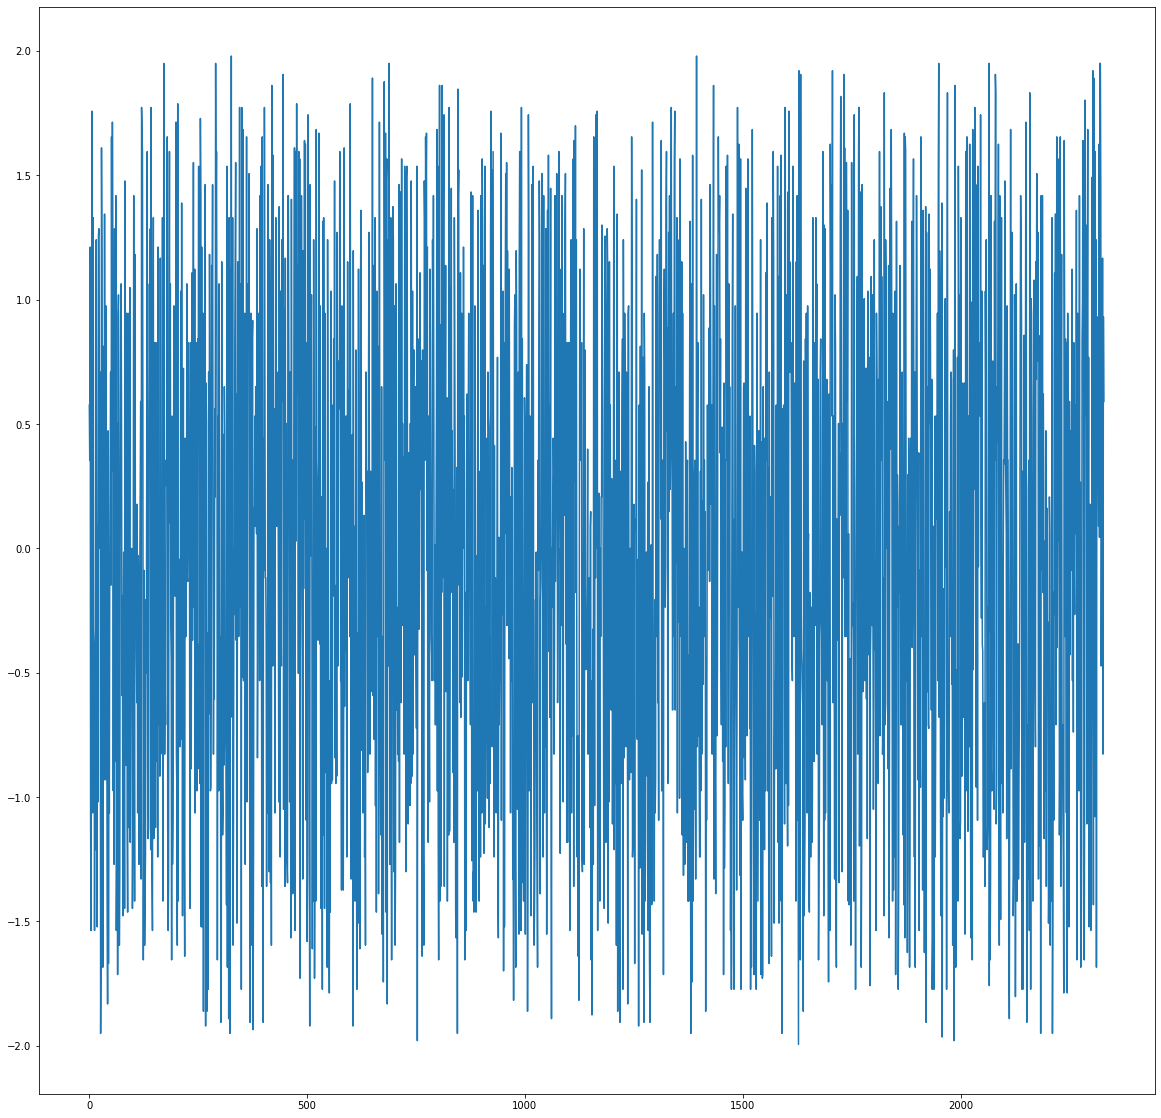

In [197]:
plt.plot(df[df["CM"]==0]["A4583"])

In [198]:
m = set(best_coefs)

In [199]:
check = lambda x: (x-1)
for a in m:
    print(f"a={a}, {check(a)}")

a=7559, 7558
a=5903, 5902
a=9743, 9742
a=6551, 6550
a=6299, 6298
a=1823, 1822
a=6047, 6046
a=7727, 7726
a=2351, 2350
a=7607, 7606
a=1847, 1846
a=4919, 4918
a=7103, 7102
a=3527, 3526
a=6599, 6598
a=4703, 4702
a=3167, 3166
a=8543, 8542
a=4583, 4582
a=9323, 9322
a=8819, 8818
a=8951, 8950
a=8447, 8446


In [200]:
m

{1823,
 1847,
 2351,
 3167,
 3527,
 4583,
 4703,
 4919,
 5903,
 6047,
 6299,
 6551,
 6599,
 7103,
 7559,
 7607,
 7727,
 8447,
 8543,
 8819,
 8951,
 9323,
 9743}

In [201]:
sorted(best_coefs)

[1823,
 1823,
 1847,
 2351,
 3167,
 3167,
 3527,
 3527,
 3527,
 3527,
 3527,
 3527,
 4583,
 4703,
 4919,
 5903,
 6047,
 6047,
 6299,
 6551,
 6551,
 6551,
 6551,
 6551,
 6551,
 6599,
 7103,
 7559,
 7607,
 7607,
 7727,
 7727,
 7727,
 7727,
 7727,
 7727,
 7727,
 7727,
 7727,
 7727,
 7727,
 7727,
 7727,
 7727,
 7727,
 7727,
 7727,
 7727,
 7727,
 8447,
 8447,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8543,
 8819,
 8951,
 8951,
 8951,
 8951,
 8951,
 9323,
 9743]